# Setup

This project requires Python 3.7 or above

In [1]:
import sys

assert sys.version_info >= (3, 7)

And Tensorflow >= 2.8:

In [2]:
from packaging import version
import tensorflow as tf

assert version.parse(tf.__version__) >= version.parse("2.8.0")

In [3]:
import matplotlib.pyplot as plt

plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

In [4]:
from pathlib import Path

IMAGES_PATH = Path() / "images" / "deep"
IMAGES_PATH.mkdir(parents=True, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = IMAGES_PATH / f"{fig_id}.{fig_extension}"
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# Vanishing/Exploding Gradients Problem

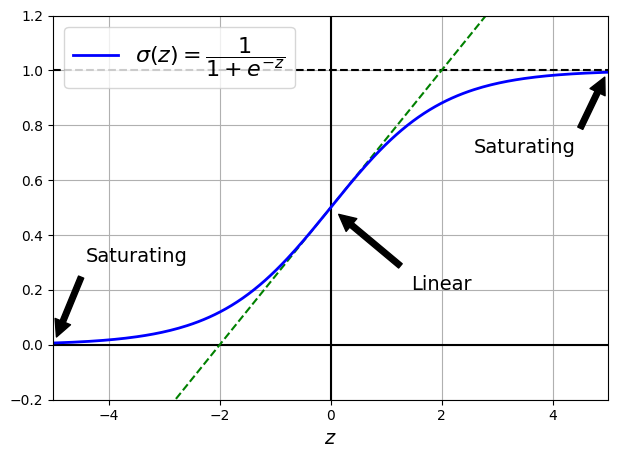

In [5]:
import numpy as np

def sigmoid(z):
    return 1 / (1 + np.exp(-z))

z = np.linspace(-5, 5, 200)

plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([-5, 5], [1, 1], 'k--')
plt.plot([0, 0], [-0.2, 1.2], 'k-')
plt.plot([-5, 5], [-3/4, 7/4], 'g--')
plt.plot(z, sigmoid(z), "b-", linewidth=2,
         label=r"$\sigma(z) = \dfrac{1}{1+e^{-z}}$")
props = dict(facecolor='black', shrink=0.1)
plt.annotate('Saturating', xytext=(3.5, 0.7), xy=(5, 1), arrowprops=props,
              fontsize=14, ha="center")
plt.annotate('Saturating', xytext=(-3.5, 0.3), xy=(-5, 0), arrowprops=props,
             fontsize=14, ha="center")
plt.annotate('Linear', xytext=(2, 0.2), xy=(0, 0.5), arrowprops=props,
             fontsize=14, ha="center")
plt.grid(True)
plt.axis([-5, 5, -0.2, 1.2])
plt.xlabel("$z$")
plt.legend(loc="upper left", fontsize=16)

save_fig("sigmoid_saturation_plot")
plt.show()

## Xavier and He Initialization

In [6]:
dense = tf.keras.layers.Dense(50, activation="relu",
                              kernel_initializer="he_normal")

In [7]:
he_avg_init = tf.keras.initializers.VarianceScaling(scale=2, mode="fan_avg",
                                                    distribution="uniform")
dense = tf.keras.layers.Dense(50, activation="sigmoid",
                              kernel_initializer=he_avg_init)

## Nonsaturating Activation Functions

### Leky ReLU

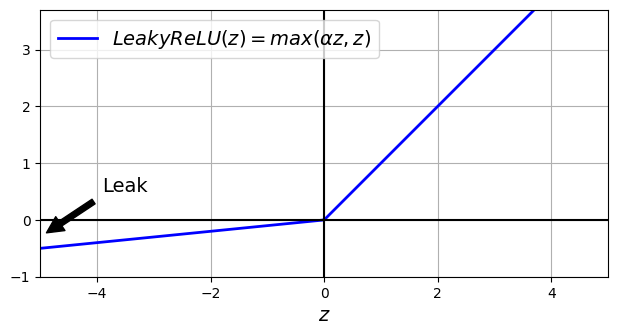

In [8]:
def leaky_relu(z, alpha):
    return np.maximum(alpha * z, z)

z = np.linspace(-5, 5, 200)
plt.plot(z, leaky_relu(z, 0.1), 'b-', linewidth=2, label=r"$LeakyReLU(z) = max(\alpha z, z)$")
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([0, 0], [-1, 3.7], 'k-')
plt.grid(True)
props = dict(facecolor='black', shrink=0.1)
plt.annotate('Leak', xytext=(-3.5, 0.5), xy=(-5, -0.3), arrowprops=props,
             fontsize=14, ha="center")
plt.xlabel("$z$")
plt.axis([-5, 5, -1, 3.7])
plt.gca().set_aspect("equal")
plt.legend()

save_fig("leaky_relu_plot")
plt.show()

In [9]:
leaky_relu = tf.keras.layers.LeakyReLU(alpha=0.2)
dense = tf.keras.layers.Dense(50, activation=leaky_relu,
                              kernel_initializer="he_normal")

In [10]:
model = tf.keras.models.Sequential([
    # [...]  # more layers
    tf.keras.layers.Dense(50, kernel_initializer="he_normal"),  # no activation
    tf.keras.layers.LeakyReLU(alpha=0.2),  # activation as a separate layer
    # [...]  # more layers
])

### ELU

In [11]:
dense = tf.keras.layers.Dense(50, activation="elu", 
                              kernel_initializer="he_normal")

### SELU

By default, the SELU hyperparamaters (`scale` and `alpha`) are tuned in such a way that the mean output of each neuron remains close to 0, and the standard deviation remains close to 1 (assuming the inputs are standardized with mean 0 and standard deviation 1 too, and other constraints are respected, as explained in the book). Using this activation function, even a 1,000 layer deep neural network preserves roughly mean 0 and standard deviation 1 across the exploding/vanishing gradients problem:

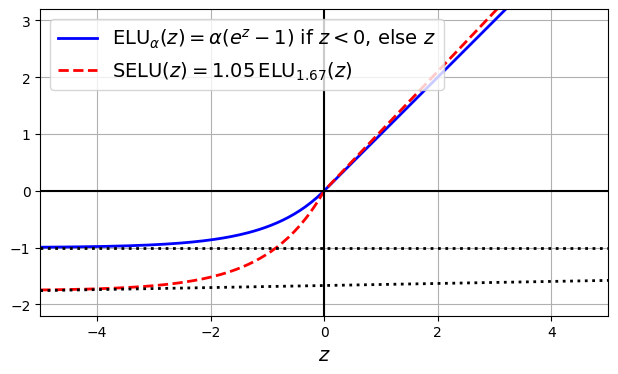

In [12]:
from scipy.special import erfc

# alpha and scale to self normalize with mean 0 and standard deviation 1
# (see equation 14 in the paper)
alpha_0_1 = -np.sqrt(2 / np.pi) / (erfc(1 / np.sqrt(2)) * np.exp(1 / 2) - 1)
scale_0_1 = (
    (1 - erfc(1 / np.sqrt(2)) * np.sqrt(np.e))
    * np.sqrt(2 * np.pi)
    * (
        2 * erfc(np.sqrt(2)) * np.e ** 2
        + np.pi * erfc(1 / np.sqrt(2)) ** 2 * np.e
        - 2 * (2 + np.pi) * erfc(1 / np.sqrt(2)) * np.sqrt(np.e)
        + np.pi
        + 2
    ) ** (-1 / 2)
)

def elu(z, alpha=1):
    return np.where(z < 0, alpha * (np.exp(z) - 1), z)

def selu(z, scale=scale_0_1, alpha=alpha_0_1):
    return scale * elu(z, alpha)

z = np.linspace(-5, 5, 200)
plt.plot(z, elu(z), "b-", linewidth=2, label=r"ELU$_\alpha(z) = \alpha (e^z - 1)$ if $z < 0$, else $z$")
plt.plot(z, selu(z), "r--", linewidth=2, label=r"SELU$(z) = 1.05 \, $ELU$_{1.67}(z)$")
plt.plot([-5, 5], [0, 0], "k-")
plt.plot([-5, 5], [-1, -1], "k:", linewidth=2)
plt.plot([-5, 5], [-1.758, -1.578], "k:", linewidth=2)
plt.plot([0, 0], [-2.2, 3.2], "k-")
plt.grid(True)
plt.axis([-5, 5, -2.2, 3.2])
plt.xlabel("$z$")
plt.gca().set_aspect("equal")
plt.legend()

save_fig("elu_selu_plot")
plt.show()


In [13]:
dense = tf.keras.layers.Dense(50, activation="selu",
                              kernel_initializer="lecun_normal")

__An example of a self-regularized network using SELU__

In [14]:
tf.random.set_seed(42)
model = tf.keras.Sequential()
model.add(tf.keras.layers.Flatten(input_shape=[28, 28]))
for layer in range(100):
    model.add(tf.keras.layers.Dense(100, activation="selu",
                                    kernel_initializer="lecun_normal"))
model.add(tf.keras.layers.Dense(10, activation="softmax"))

In [15]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=tf.keras.optimizers.SGD(learning_rate=0.001),
              metrics=["accuracy"])

Don't forget to scale the inputs to mean 0 and standard deviation 1

In [16]:
fashion_mnist = tf.keras.datasets.mnist.load_data()
(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist
X_train, y_train = X_train_full[:-5000], y_train_full[:-5000]
X_valid, y_valid = X_train_full[-5000:], y_train_full[-5000:]
X_train, X_valid, X_test = X_train / 255, X_valid / 255, X_test / 255

In [17]:
class_names = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
               "Sandal", "Shirt", "Sneaker", "Bag", "Ankle Boot"]

In [18]:
pixel_means = X_train.mean(axis=0, keepdims=True)
pixel_stds = X_train.std(axis=0, keepdims=True)
X_train_scaled = (X_train - pixel_means) / pixel_stds
X_valid_scaled = (X_valid - pixel_means) / pixel_stds
X_test_scaled = (X_test - pixel_means) / pixel_stds

C:\Users\HP\AppData\Local\Temp\ipykernel_14468\2231411249.py:3: RuntimeWarning: invalid value encountered in divide
  X_train_scaled = (X_train - pixel_means) / pixel_stds
C:\Users\HP\AppData\Local\Temp\ipykernel_14468\2231411249.py:4: RuntimeWarning: invalid value encountered in divide
  X_valid_scaled = (X_valid - pixel_means) / pixel_stds
C:\Users\HP\AppData\Local\Temp\ipykernel_14468\2231411249.py:5: RuntimeWarning: divide by zero encountered in divide
  X_test_scaled = (X_test - pixel_means) / pixel_stds
C:\Users\HP\AppData\Local\Temp\ipykernel_14468\2231411249.py:5: RuntimeWarning: invalid value encountered in divide
  X_test_scaled = (X_test - pixel_means) / pixel_stds


In [19]:
history = model.fit(X_train_scaled, y_train, epochs=5,
                    validation_data=(X_valid_scaled, y_valid))

Epoch 1/5
1719/1719 [==============================] - 36s 18ms/step - loss: nan - accuracy: 0.0988 - val_loss: nan - val_accuracy: 0.0978
Epoch 2/5
1719/1719 [==============================] - 28s 17ms/step - loss: nan - accuracy: 0.0988 - val_loss: nan - val_accuracy: 0.0978
Epoch 3/5
1719/1719 [==============================] - 29s 17ms/step - loss: nan - accuracy: 0.0988 - val_loss: nan - val_accuracy: 0.0978
Epoch 4/5
1719/1719 [==============================] - 29s 17ms/step - loss: nan - accuracy: 0.0988 - val_loss: nan - val_accuracy: 0.0978
Epoch 5/5
1719/1719 [==============================] - 28s 17ms/step - loss: nan - accuracy: 0.0988 - val_loss: nan - val_accuracy: 0.0978


The network managed to learn, despite how deep it is. Now look at what happens if we try to use the ReLU activation function instead.

In [20]:
tf.random.set_seed(42)

In [21]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Flatten(input_shape=[28, 28]))
for layer in range(100):
    model.add(tf.keras.layers.Dense(100, activation="relu",
                                    kernel_initializer="he_normal"))
model.add(tf.keras.layers.Dense(10, activation="softmax"))

In [22]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=tf.keras.optimizers.SGD(learning_rate=0.001),
              metrics=["accuracy"])

In [23]:
history = model.fit(X_train, y_train, epochs=5,
                    validation_data=(X_valid_scaled, y_valid))

Epoch 1/5
1719/1719 [==============================] - 32s 17ms/step - loss: 1.9915 - accuracy: 0.2433 - val_loss: nan - val_accuracy: 0.0978
Epoch 2/5
1719/1719 [==============================] - 28s 16ms/step - loss: 1.4101 - accuracy: 0.4192 - val_loss: nan - val_accuracy: 0.0978
Epoch 3/5
1719/1719 [==============================] - 28s 16ms/step - loss: 1.1432 - accuracy: 0.5402 - val_loss: nan - val_accuracy: 0.0978
Epoch 4/5
1719/1719 [==============================] - 29s 17ms/step - loss: 0.9852 - accuracy: 0.6488 - val_loss: nan - val_accuracy: 0.0978
Epoch 5/5
1719/1719 [==============================] - 34s 20ms/step - loss: 0.7090 - accuracy: 0.7731 - val_loss: nan - val_accuracy: 0.0978


Not great at all, we suffered from the vanishing/exploding gradient problem.

### GELU, Swish and Mish

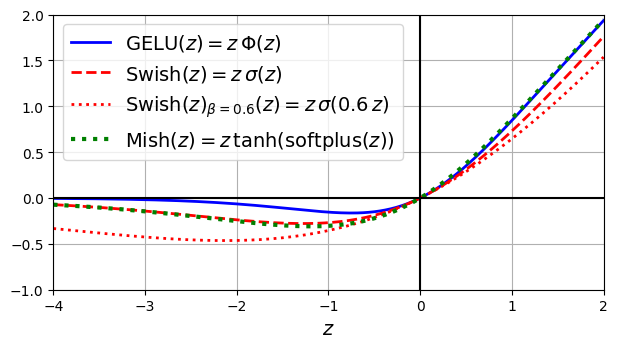

In [24]:
def swish(z, beta=1):
    return z * sigmoid(beta * z)

def approx_gelu(z):
    return swish(z, beta=1.702)

def softplus(z):
    return np.log(1 + np.exp(z))

def mish(z):
    return z * np.tanh(softplus(z))

z = np.linspace(-4, 2, 200)

beta = 0.6
plt.plot(z, approx_gelu(z), "b-", linewidth=2,
         label=r"GELU$(z) = z\,\Phi(z)$")
plt.plot(z, swish(z), "r--", linewidth=2,
         label=r"Swish$(z) = z\,\sigma(z)$")
plt.plot(z, swish(z, beta), "r:", linewidth=2,
         label=fr"Swish$(z)_{{\beta={beta}}}(z)=z\,\sigma({beta}\,z)$")
plt.plot(z, mish(z), "g:", linewidth=3,
         label=fr"Mish$(z) = z\,\tanh($softplus$(z))$")
plt.plot([-4, 2], [0, 0], "k-")
plt.plot([0, 0], [-2.2, 3.2], "k-")
plt.grid(True)
plt.axis([-4, 2, -1, 2])
plt.gca().set_aspect("equal")
plt.xlabel("$z$")
plt.legend(loc="upper left")

save_fig("gelu_swish_mish_plot")
plt.show()

# Batch Normalization

Batch normalizing algorithm

1. $\boldsymbol{\mu}_{B} = \frac{1}{m_{B}}\sum \limits _{i=1} ^ {m_{B}} \boldsymbol{x}^{(i)}$
2. $\boldsymbol{\sigma}_{B}^{2} = \frac{1}{m_{B}}\sum \limits _{i=1} ^ {m_{B}} ({\boldsymbol{x}^{(i)} - \boldsymbol{\mu}_{B}})^{2}$
3. $\hat{\boldsymbol{x}}^{(i)} = \frac{\boldsymbol{x}^{(i)} - \boldsymbol{\mu}_{B}}{\sqrt{{\boldsymbol{\sigma}_B^{2}}+{\epsilon}}}$
4. $\boldsymbol{z}^{(i)}=\boldsymbol{\gamma}\otimes{\hat{\boldsymbol{x}}^{(i)}} + \boldsymbol{\beta}$

In this algorithm:
- $\boldsymbol{\mu}_{B}$ is the vector of input means, evaluated over the whole mini-batch _B_ (it contains one mean per input).
- $m_B$ is the number of instances in the mini-batch.
- $\boldsymbol{\sigma}_{B}$ is the vector of input standard deviations, also evaluated over the whole mini-batch (it contains one standard deviation per input).
- $\hat{\boldsymbol{x}^{(i)}}$ is the vector of zero-centered and normalized inputs for instance _i_.
- $\epsilon$ is a tiny number that avoids division by zero and ensures the gradients don't grow too large (typically $10^{-5}$). This is called _smoothing term_.
- $\boldsymbol{\gamma}$ is the output scale parameter vector for the layer (each input is multiplied by its correcter per input).
- $\otimes$ represents element-wise multiplication (each input is multiplied by its corresponding output scale parameter).
- $\boldsymbol{\beta}$ is the output shift (offset) parameter vector for the layer (it contains one offset parameter per input). Each input is offset by its corresponding shift parameter.
- **z**<sup>(i)</sup> is the output of the BN operation. It is a rescaled and shifted version of the inputs. 

In [25]:
tf.keras.backend.clear_session()
tf.random.set_seed(42)

In [26]:
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=[28, 28]),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(300, activation="relu",
                          kernel_initializer="he_normal"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(100, activation="relu",
                          kernel_initializer="he_normal"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(10, activation="softmax")
])

In [27]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 batch_normalization (BatchN  (None, 784)              3136      
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 300)               235500    
                                                                 
 batch_normalization_1 (Batc  (None, 300)              1200      
 hNormalization)                                                 
                                                                 
 dense_1 (Dense)             (None, 100)               30100     
                                                                 
 batch_normalization_2 (Batc  (None, 100)              4

In [28]:
[(var.name, var.trainable) for var in model.layers[1].variables]

[('batch_normalization/gamma:0', True),
 ('batch_normalization/beta:0', True),
 ('batch_normalization/moving_mean:0', False),
 ('batch_normalization/moving_variance:0', False)]

In [29]:
model.compile(loss="sparse_categorical_crossentropy", optimizer="sgd",
              metrics="accuracy")
model.fit(X_train, y_train, epochs=2, validation_data=(X_valid, y_valid))

Epoch 1/2
1719/1719 [==============================] - 9s 4ms/step - loss: 0.3902 - accuracy: 0.8812 - val_loss: 0.1625 - val_accuracy: 0.9552
Epoch 2/2
1719/1719 [==============================] - 7s 4ms/step - loss: 0.2033 - accuracy: 0.9399 - val_loss: 0.1276 - val_accuracy: 0.9638


Sometimes applying BN before the activation function works better (there's a debate on this topic). Moreover, the layer before a `BatchNormalization` layer does not need to have bias terms, since the `BatchNormalization` layer some as well, it would be a waste of parameters, so you can set `use_bias=False` when creating those layers:

In [30]:
tf.keras.backend.clear_session()
tf.random.set_seed(42)

In [31]:
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=[28, 28]),
    tf.keras.layers.Dense(300, kernel_initializer="he_normal", use_bias=False),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation("relu"),
    tf.keras.layers.Dense(100, kernel_initializer="he_normal", use_bias=False),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation("relu"),
    tf.keras.layers.Dense(10, activation="softmax")
])

In [32]:
model.compile(loss="sparse_categorical_crossentropy", optimizer="sgd",
              metrics="accuracy")
model.fit(X_train, y_train, epochs=2, validation_data=(X_valid, y_valid))

Epoch 1/2
1719/1719 [==============================] - 7s 4ms/step - loss: 0.4594 - accuracy: 0.8754 - val_loss: 0.1708 - val_accuracy: 0.9574
Epoch 2/2
1719/1719 [==============================] - 6s 3ms/step - loss: 0.2264 - accuracy: 0.9355 - val_loss: 0.1241 - val_accuracy: 0.9688


## Gradient Clipping

Technique to mitigate exploding gradients problem.

All `tf.keras.optimizers` accept `clipnorm` or `clipvalue` arguments:

In [33]:
optimizer = tf.keras.optimizers.SGD(clipvalue=1.0)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer)

In [34]:
optimizer = tf.keras.optimizers.SGD(clipnorm=1.0)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer)

## Reusing Pretrained Layers

### Reusing a Keras model

Let's split the fashion MNIST training set in two:
- `X_train_A`: all images of all items except for T-shirts/tops and pullovers (classes 0 and 2).
- `X_train_B`: a much smaller training set of just the first 200 images of T-shirts/tops and pullovers.

The validation set and the test set are also split this way, but without restricting the number of images.

We will train a model on set A (classification task with 8 classes), and try reusing it to tackle set B (binary classification). We hope to transfer a little bit of knowledge from task A to task B, since classes in set A (trousers, dresses, coats, sandals, shirts, sneakers, bags and ankle boots) are somewhat similar to classes in set B (T-shirts/tops and pullovers). However, since we are using `Dense` layers, only patterns that occur at the same location can be reused (in contrast, convolutional layers will transfer much better, since learned patterns can be detected anywhere on the image).

In [35]:
pos_class_id = class_names.index("Pullover")
neg_class_id = class_names.index("T-shirt/top")

def split_dataset(X, y):
    y_for_B = (y == pos_class_id) | (y == neg_class_id)
    y_A = y[~y_for_B]
    y_B = (y[y_for_B] == pos_class_id).astype(np.float32)
    old_class_ids = list(set(range(10)) - set([neg_class_id, pos_class_id]))
    for old_class_id, new_class_id in zip(old_class_ids, range(8)):
        y_A[y_A == old_class_id] = new_class_id  # reorder class ids for A
    return ((X[~y_for_B], y_A), (X[y_for_B], y_B))

(X_train_A, y_train_A), (X_train_B, y_train_B) = split_dataset(X_train, y_train)
(X_valid_A, y_valid_A), (X_valid_B, y_valid_B) = split_dataset(X_valid, y_valid)
(X_test_A, y_test_A), (X_test_B, y_test_B) = split_dataset(X_test, y_test)
X_train_B = X_train_B[:200]
y_train_B = y_train_B[:200]

tf.random.set_seed(42)

model_A = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=[28, 28]),
    tf.keras.layers.Dense(100, activation="relu",
                          kernel_initializer="he_normal"),
    tf.keras.layers.Dense(100, activation="relu",
                          kernel_initializer="he_normal"),
    tf.keras.layers.Dense(100, activation="relu",
                          kernel_initializer="he_normal"),
    tf.keras.layers.Dense(8, activation="softmax")
])

model_A.compile(loss="sparse_categorical_crossentropy",
                optimizer=tf.keras.optimizers.SGD(learning_rate=0.001),
                metrics=["accuracy"])
history = model_A.fit(X_train_A, y_train_A, epochs=20,
                      validation_data=(X_valid_A, y_valid_A))
model_A.save("my_model_A")

Epoch 1/20
1379/1379 [==============================] - 4s 3ms/step - loss: 1.5638 - accuracy: 0.5273 - val_loss: 0.9183 - val_accuracy: 0.7875
Epoch 2/20
1379/1379 [==============================] - 3s 2ms/step - loss: 0.7111 - accuracy: 0.8137 - val_loss: 0.4679 - val_accuracy: 0.8892
Epoch 3/20
1379/1379 [==============================] - 3s 2ms/step - loss: 0.4728 - accuracy: 0.8687 - val_loss: 0.3446 - val_accuracy: 0.9131
Epoch 4/20
1379/1379 [==============================] - 3s 2ms/step - loss: 0.3890 - accuracy: 0.8884 - val_loss: 0.2942 - val_accuracy: 0.9223
Epoch 5/20
1379/1379 [==============================] - 3s 2ms/step - loss: 0.3463 - accuracy: 0.8983 - val_loss: 0.2650 - val_accuracy: 0.9276
Epoch 6/20
1379/1379 [==============================] - 3s 2ms/step - loss: 0.3187 - accuracy: 0.9048 - val_loss: 0.2462 - val_accuracy: 0.9301
Epoch 7/20
1379/1379 [==============================] - 3s 2ms/step - loss: 0.2987 - accuracy: 0.9108 - val_loss: 0.2338 - val_accuracy:

In [36]:
# train and evaluate model B, without using model A

tf.random.set_seed(42)
model_B = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=[28, 28]),
    tf.keras.layers.Dense(100, activation="relu",
                          kernel_initializer="he_normal"),
    tf.keras.layers.Dense(100, activation="relu",
                          kernel_initializer="he_normal"),
    tf.keras.layers.Dense(100, activation="relu",
                          kernel_initializer="he_normal"),
    tf.keras.layers.Dense(1, activation="sigmoid")
])

model_B.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.SGD(learning_rate=0.001),
                metrics=["accuracy"])
history = model_B.fit(X_train_B, y_train_B, epochs=20,
                      validation_data=(X_valid_B, y_valid_B))
model_B.evaluate(X_test_B, y_test_B)

Epoch 1/20
7/7 [==============================] - 1s 49ms/step - loss: 0.6877 - accuracy: 0.5750 - val_loss: 0.6720 - val_accuracy: 0.5886
Epoch 2/20
7/7 [==============================] - 0s 23ms/step - loss: 0.6762 - accuracy: 0.6350 - val_loss: 0.6620 - val_accuracy: 0.6253
Epoch 3/20
7/7 [==============================] - 0s 25ms/step - loss: 0.6660 - accuracy: 0.6700 - val_loss: 0.6519 - val_accuracy: 0.6650
Epoch 4/20
7/7 [==============================] - 0s 21ms/step - loss: 0.6559 - accuracy: 0.6850 - val_loss: 0.6423 - val_accuracy: 0.7077
Epoch 5/20
7/7 [==============================] - 0s 22ms/step - loss: 0.6465 - accuracy: 0.7150 - val_loss: 0.6328 - val_accuracy: 0.7332
Epoch 6/20
7/7 [==============================] - 0s 23ms/step - loss: 0.6371 - accuracy: 0.7400 - val_loss: 0.6228 - val_accuracy: 0.7515
Epoch 7/20
7/7 [==============================] - 0s 20ms/step - loss: 0.6274 - accuracy: 0.7700 - val_loss: 0.6133 - val_accuracy: 0.7729
Epoch 8/20
7/7 [===========

[0.5185073614120483, 0.8841948509216309]

Model B reaches 84.84% accuracy on the test set. Now let's try reusing the pretrained model A.

In [37]:
model_A = tf.keras.models.load_model("my_model_A")
model_B_on_A = tf.keras.Sequential(model_A.layers[:-1])
model_B_on_A.add(tf.keras.layers.Dense(1, activation="sigmoid"))

Note that `model_B_on_A` and `model_A` actually share layers now, so when we train one, it will update both models. If we want to avoid that, we need to build `model_B_on_A` on top of a _clone_ of `model_A`:

In [38]:
tf.random.set_seed(42)

In [39]:
model_A_clone = tf.keras.models.clone_model(model_A)
model_A_clone.set_weights(model_A.get_weights())

`tf.keras.models.clone_model()` only clones the architecture, not the weights. If you don't copy them manually using `set_weights()`, they will be initialized randomly when the cloned model is first used. 

In [40]:
model_B_on_A = tf.keras.Sequential(model_A_clone.layers[:-1])
model_B_on_A.add(tf.keras.layers.Dense(1, activation="sigmoid"))

Since the new output layer was initialized randomly it will make large errors (at least during the first few epochs), so there will be large error gradients that may wreck the reused weights. To avoid this, one approach is to freeze the reused layers during the first few epochs, giving the new layer some time to learn reasonable weights.

In [41]:
for layer in model_B_on_A.layers[:-1]:
    layer.trainable = False

optimizer = tf.keras.optimizers.SGD(learning_rate=0.001)
model_B_on_A.compile(loss="binary_crossentropy", optimizer=optimizer,
                     metrics=["accuracy"])

Now, train the model for a few epochs, then unfreeze the reused layers (which requires compiling the model again) and continue training to fine-tune the reused layers for task B. After unfreezing the reused layers, it is usualy a good idea to reduce the learning rate, once again to avoid damaging the reused weights.

In [42]:
history = model_B_on_A.fit(X_train_B, y_train_B, epochs=4,
                           validation_data=(X_valid_B, y_valid_B))

for layer in model_B_on_A.layers[:-1]:
    layer.trainable = True

optimizer = tf.keras.optimizers.SGD(learning_rate=0.001)
model_B_on_A.compile(loss="binary_crossentropy", optimizer=optimizer,
                     metrics=["accuracy"])
history = model_B_on_A.fit(X_train_B, y_train_B, epochs=16,
                           validation_data=(X_valid_B, y_valid_B))

Epoch 1/4


7/7 [==============================] - 1s 51ms/step - loss: 1.3327 - accuracy: 0.3350 - val_loss: 1.2379 - val_accuracy: 0.3442
Epoch 2/4
7/7 [==============================] - 0s 21ms/step - loss: 1.1980 - accuracy: 0.3300 - val_loss: 1.1555 - val_accuracy: 0.3350
Epoch 3/4
7/7 [==============================] - 0s 21ms/step - loss: 1.1229 - accuracy: 0.3550 - val_loss: 1.0932 - val_accuracy: 0.3462
Epoch 4/4
7/7 [==============================] - 0s 20ms/step - loss: 1.0682 - accuracy: 0.3700 - val_loss: 1.0499 - val_accuracy: 0.3564
Epoch 1/16
7/7 [==============================] - 1s 48ms/step - loss: 0.9932 - accuracy: 0.4050 - val_loss: 0.9126 - val_accuracy: 0.4369
Epoch 2/16
7/7 [==============================] - 0s 22ms/step - loss: 0.8765 - accuracy: 0.4850 - val_loss: 0.8122 - val_accuracy: 0.4939
Epoch 3/16
7/7 [==============================] - 0s 19ms/step - loss: 0.7843 - accuracy: 0.5350 - val_loss: 0.7329 - val_accuracy: 0.5703
Epoch 4/16
7/7 [=========================

In [43]:
model_B_on_A.evaluate(X_test_B, y_test_B)

63/63 [==============================] - 0s 2ms/step - loss: 0.3038 - accuracy: 0.9090


[0.30384212732315063, 0.9090456962585449]

The model's accuracy went up 10 percentage points, from 84.84% to 93.98%

Training a deep neural network can be painfully slow. So far we have seen four ways to speed up training (and reach a better solution): applying a good initialization strategy for the connection weights, using a good activation function, using batch normalization, and reusing parts of a pretrained network (possibly built for an auxiliary task or using unsupervised learning). Another huge speed boost comes from using a faster optimizer than the regular gradient descent optimizer. 

Popular optimization algorithms: momentum, Nesterov accelerated gradient, AdaGrad, RMSProp, and Adam and its variants

# Faster Optimizers

Gradient Descent algorithm:

$\boldsymbol\theta \leftarrow \boldsymbol\theta - \eta{\Delta_{\boldsymbol\theta}}J(\boldsymbol\theta)$

In [44]:
# a little function to test an optimizer on Fashion MNIST

def build_model(seed=42):
    tf.random.set_seed(seed)
    return tf.keras.Sequential([
        tf.keras.layers.Flatten(input_shape=[28, 28]),
        tf.keras.layers.Dense(100, activation="relu",
                              kernel_initializer="he_normal"),
        tf.keras.layers.Dense(100, activation="relu",
                              kernel_initializer="he_normal"),
        tf.keras.layers.Dense(100, activation="relu",
                              kernel_initializer="he_normal"),
        tf.keras.layers.Dense(10, activation="softmax")
    ])

def build_and_train_model(optimizer):
    model = build_model()
    model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
                  metrics=["accuracy"])
    return model.fit(X_train, y_train, epochs=10,
                     validation_data=(X_valid, y_valid))

In [63]:
optimizer = tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.9)

In [64]:
history_sgd = build_and_train_model(optimizer)

Epoch 1/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.5865 - accuracy: 0.8324 - val_loss: 0.2206 - val_accuracy: 0.9404
Epoch 2/10
1719/1719 [==============================] - 4s 3ms/step - loss: 0.2476 - accuracy: 0.9277 - val_loss: 0.1748 - val_accuracy: 0.9532
Epoch 3/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.1951 - accuracy: 0.9431 - val_loss: 0.1498 - val_accuracy: 0.9610
Epoch 4/10
1719/1719 [==============================] - 4s 3ms/step - loss: 0.1633 - accuracy: 0.9519 - val_loss: 0.1304 - val_accuracy: 0.9630
Epoch 5/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.1396 - accuracy: 0.9591 - val_loss: 0.1184 - val_accuracy: 0.9684
Epoch 6/10
1719/1719 [==============================] - 4s 3ms/step - loss: 0.1225 - accuracy: 0.9632 - val_loss: 0.1083 - val_accuracy: 0.9708
Epoch 7/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.1085 - accuracy: 0.9677 - val_loss: 0.1013 - val_accuracy:

## Momentum optimization

Momentum algorithm

1. $\boldsymbol{m} \leftarrow \beta\boldsymbol{m} - \eta\Delta_{\boldsymbol\theta}J(\boldsymbol\theta)$
2. $\boldsymbol\theta \leftarrow \boldsymbol\theta + \boldsymbol{m}$

In [65]:
optimizer = tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.9)

In [66]:
history_momentum = build_and_train_model(optimizer)

Epoch 1/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.5550 - accuracy: 0.8397 - val_loss: 0.2251 - val_accuracy: 0.9396
Epoch 2/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.2504 - accuracy: 0.9262 - val_loss: 0.1819 - val_accuracy: 0.9474
Epoch 3/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.1971 - accuracy: 0.9422 - val_loss: 0.1500 - val_accuracy: 0.9576
Epoch 4/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.1659 - accuracy: 0.9507 - val_loss: 0.1306 - val_accuracy: 0.9630
Epoch 5/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.1427 - accuracy: 0.9580 - val_loss: 0.1226 - val_accuracy: 0.9676
Epoch 6/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.1259 - accuracy: 0.9628 - val_loss: 0.1085 - val_accuracy: 0.9692
Epoch 7/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.1122 - accuracy: 0.9663 - val_loss: 0.1009 - val_accuracy:

## Nesterov Accelerated Gradient

Nesterov accelerated gradient algorithm

1. $\boldsymbol{m} \leftarrow \beta\boldsymbol{m} - \eta\Delta_\theta J(\boldsymbol\theta + \beta\boldsymbol{m})$
2. $\boldsymbol\theta \leftarrow \boldsymbol\theta + \boldsymbol{m}$

In [47]:
optimizer = tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.9,
                                    nesterov=True)

In [48]:
history_nesterov = build_and_train_model(optimizer)

Epoch 1/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.5378 - accuracy: 0.8473 - val_loss: 0.2135 - val_accuracy: 0.9400
Epoch 2/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.2403 - accuracy: 0.9304 - val_loss: 0.1781 - val_accuracy: 0.9500
Epoch 3/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.1902 - accuracy: 0.9458 - val_loss: 0.1508 - val_accuracy: 0.9596
Epoch 4/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.1612 - accuracy: 0.9537 - val_loss: 0.1260 - val_accuracy: 0.9674
Epoch 5/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.1393 - accuracy: 0.9597 - val_loss: 0.1202 - val_accuracy: 0.9676
Epoch 6/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.1233 - accuracy: 0.9640 - val_loss: 0.1112 - val_accuracy: 0.9696
Epoch 7/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.1103 - accuracy: 0.9677 - val_loss: 0.1061 - val_accuracy:

## AdaGrad

AdaGrad algorithm:

1. $\boldsymbol{s} \leftarrow \boldsymbol{s} + \Delta_{\boldsymbol\theta} J(\boldsymbol\theta) \otimes \Delta_{\boldsymbol\theta} J(\boldsymbol\theta)$
2. $\boldsymbol\theta \leftarrow \boldsymbol\theta - \eta\Delta_{\boldsymbol\theta} J(\boldsymbol\theta) \oslash \sqrt{\boldsymbol{s} + \epsilon}$

In [49]:
optimizer = tf.keras.optimizers.Adagrad(learning_rate=0.001)

In [50]:
history_adagrad = build_and_train_model(optimizer)

Epoch 1/10
1719/1719 [==============================] - 6s 3ms/step - loss: 1.1893 - accuracy: 0.6692 - val_loss: 0.5217 - val_accuracy: 0.8770
Epoch 2/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.4940 - accuracy: 0.8679 - val_loss: 0.3464 - val_accuracy: 0.9110
Epoch 3/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.3906 - accuracy: 0.8919 - val_loss: 0.2915 - val_accuracy: 0.9212
Epoch 4/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.3460 - accuracy: 0.9029 - val_loss: 0.2644 - val_accuracy: 0.9284
Epoch 5/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.3191 - accuracy: 0.9098 - val_loss: 0.2461 - val_accuracy: 0.9322
Epoch 6/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.2999 - accuracy: 0.9151 - val_loss: 0.2335 - val_accuracy: 0.9342
Epoch 7/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.2853 - accuracy: 0.9189 - val_loss: 0.2222 - val_accuracy:

## RMSProp

RMSProp algorithm

1. $\boldsymbol{s} \leftarrow \rho\boldsymbol{s} + (1-\rho)\Delta_{\boldsymbol\theta} J(\boldsymbol\theta) \oslash \Delta_{\boldsymbol\theta} J(\boldsymbol\theta)$
2. $\boldsymbol\theta \leftarrow \boldsymbol\theta - \eta\Delta_{\boldsymbol\theta} J(\boldsymbol\theta) \oslash \sqrt{\boldsymbol{s} + \epsilon}$

In [51]:
optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.001, rho=0.9)

In [52]:
history_rmsprop = build_and_train_model(optimizer)

Epoch 1/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.2472 - accuracy: 0.9257 - val_loss: 0.1399 - val_accuracy: 0.9566
Epoch 2/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.1194 - accuracy: 0.9653 - val_loss: 0.1110 - val_accuracy: 0.9692
Epoch 3/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.0922 - accuracy: 0.9735 - val_loss: 0.1000 - val_accuracy: 0.9768
Epoch 4/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.0748 - accuracy: 0.9791 - val_loss: 0.0885 - val_accuracy: 0.9780
Epoch 5/10
1719/1719 [==============================] - 6s 4ms/step - loss: 0.0628 - accuracy: 0.9829 - val_loss: 0.1102 - val_accuracy: 0.9778
Epoch 6/10
1719/1719 [==============================] - 6s 4ms/step - loss: 0.0580 - accuracy: 0.9840 - val_loss: 0.1299 - val_accuracy: 0.9752
Epoch 7/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.0533 - accuracy: 0.9860 - val_loss: 0.1415 - val_accuracy:

## Adam Optimization

Adam(Adaptive moment estimation) algorithm:

1. $\boldsymbol{m} \leftarrow \beta_1\boldsymbol{m} - (1-\beta_1)\Delta_{\boldsymbol\theta} J(\boldsymbol\theta)$
2. $\boldsymbol{s} \leftarrow \beta_2\boldsymbol{\boldsymbol{s}} + (1-\beta_2)\Delta_{\boldsymbol\theta} J(\boldsymbol\theta) \otimes \Delta_{\boldsymbol\theta} J(\boldsymbol\theta)$
3. $\widehat{\boldsymbol{m}} \leftarrow \frac{\boldsymbol{m}}{1-{\beta_1}^t}$
4. $\widehat{\boldsymbol{s}} \leftarrow \frac{\boldsymbol{s}}{1-{\beta_2}^t}$
5. $\boldsymbol\theta \leftarrow \eta\widehat{\boldsymbol{m}}\oslash\sqrt{\widehat{\boldsymbol{s}}+\epsilon}$

In [53]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9,
                                    beta_2=0.999)

In [54]:
history_adam = build_and_train_model(optimizer)

Epoch 1/10
1719/1719 [==============================] - 5s 2ms/step - loss: 0.2443 - accuracy: 0.9269 - val_loss: 0.1147 - val_accuracy: 0.9660
Epoch 2/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.1067 - accuracy: 0.9672 - val_loss: 0.0999 - val_accuracy: 0.9718
Epoch 3/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.0786 - accuracy: 0.9750 - val_loss: 0.0991 - val_accuracy: 0.9718
Epoch 4/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.0610 - accuracy: 0.9811 - val_loss: 0.0825 - val_accuracy: 0.9746
Epoch 5/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.0504 - accuracy: 0.9834 - val_loss: 0.0829 - val_accuracy: 0.9768
Epoch 6/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.0406 - accuracy: 0.9868 - val_loss: 0.0934 - val_accuracy: 0.9756
Epoch 7/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.0378 - accuracy: 0.9874 - val_loss: 0.0898 - val_accuracy:

### Adamax Optimization

In [55]:
optimizer = tf.keras.optimizers.Adamax(learning_rate=0.001, beta_1=0.9,
                                        beta_2=0.999)

In [56]:
history_adamax = build_and_train_model(optimizer)

Epoch 1/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.3265 - accuracy: 0.9058 - val_loss: 0.1398 - val_accuracy: 0.9618
Epoch 2/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.1549 - accuracy: 0.9542 - val_loss: 0.1140 - val_accuracy: 0.9686
Epoch 3/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.1142 - accuracy: 0.9660 - val_loss: 0.0951 - val_accuracy: 0.9724
Epoch 4/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.0915 - accuracy: 0.9730 - val_loss: 0.0891 - val_accuracy: 0.9752
Epoch 5/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.0755 - accuracy: 0.9775 - val_loss: 0.0874 - val_accuracy: 0.9770
Epoch 6/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.0633 - accuracy: 0.9816 - val_loss: 0.0852 - val_accuracy: 0.9764
Epoch 7/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.0549 - accuracy: 0.9836 - val_loss: 0.0829 - val_accuracy:

### Nadam Optimzation

In [57]:
optimizer = tf.keras.optimizers.Nadam(learning_rate=0.001, beta_1=0.9,
                                      beta_2=0.999)

In [58]:
history_nadam = build_and_train_model(optimizer)

Epoch 1/10
1719/1719 [==============================] - 9s 5ms/step - loss: 0.2410 - accuracy: 0.9279 - val_loss: 0.1030 - val_accuracy: 0.9706
Epoch 2/10
1719/1719 [==============================] - 9s 5ms/step - loss: 0.1050 - accuracy: 0.9679 - val_loss: 0.0881 - val_accuracy: 0.9734
Epoch 3/10
1719/1719 [==============================] - 9s 5ms/step - loss: 0.0758 - accuracy: 0.9764 - val_loss: 0.0928 - val_accuracy: 0.9740
Epoch 4/10
1719/1719 [==============================] - 8s 5ms/step - loss: 0.0594 - accuracy: 0.9813 - val_loss: 0.1018 - val_accuracy: 0.9714
Epoch 5/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.0489 - accuracy: 0.9841 - val_loss: 0.0988 - val_accuracy: 0.9736
Epoch 6/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.0392 - accuracy: 0.9874 - val_loss: 0.1050 - val_accuracy: 0.9748
Epoch 7/10
1719/1719 [==============================] - 8s 5ms/step - loss: 0.0369 - accuracy: 0.9880 - val_loss: 0.1011 - val_accuracy:

### AdamW Optimization

In [59]:
if "google.colab" in sys.modules:
    %pip install -q -U tensorflow-addons

In [67]:
import tensorflow_addons as tfa

optimizer = tfa.optimizers.AdamW(weight_decay=1e-5, learning_rate=0.001,
                                 beta_1=0.9, beta_2=0.999)

In [62]:
history_adamw = build_and_train_model(optimizer)

Epoch 1/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.2518 - accuracy: 0.9238 - val_loss: 0.1161 - val_accuracy: 0.9654
Epoch 2/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.1103 - accuracy: 0.9663 - val_loss: 0.0940 - val_accuracy: 0.9726
Epoch 3/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.0803 - accuracy: 0.9749 - val_loss: 0.0781 - val_accuracy: 0.9772
Epoch 4/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.0622 - accuracy: 0.9806 - val_loss: 0.0945 - val_accuracy: 0.9714
Epoch 5/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.0503 - accuracy: 0.9833 - val_loss: 0.0789 - val_accuracy: 0.9758
Epoch 6/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.0426 - accuracy: 0.9861 - val_loss: 0.0948 - val_accuracy: 0.9746
Epoch 7/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.0376 - accuracy: 0.9876 - val_loss: 0.0983 - val_accuracy:

### Learning curves of all the optimizers

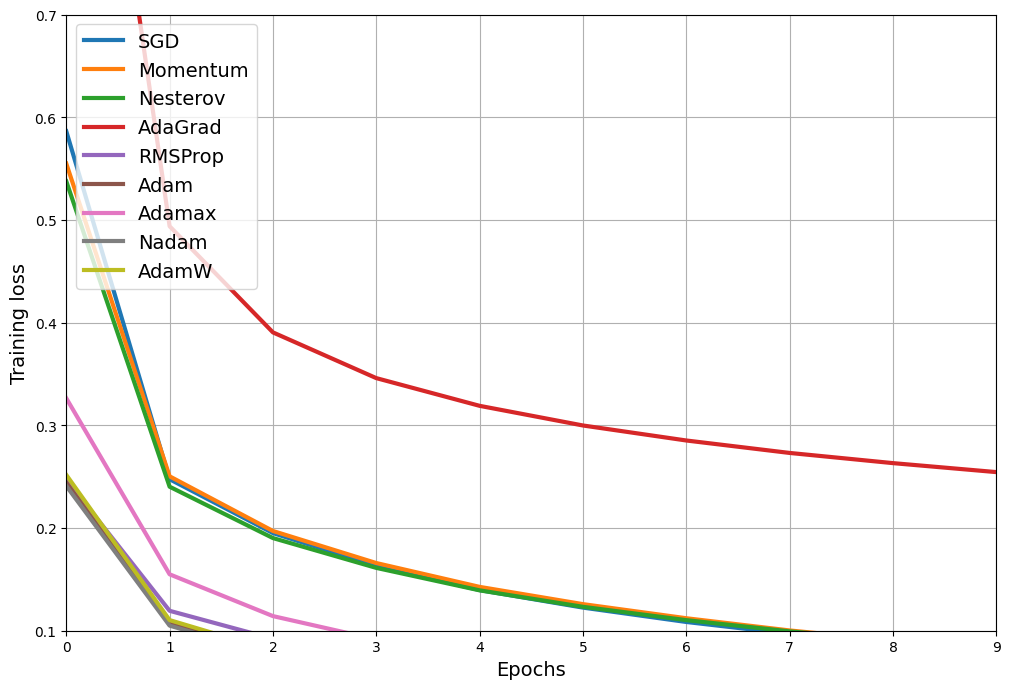

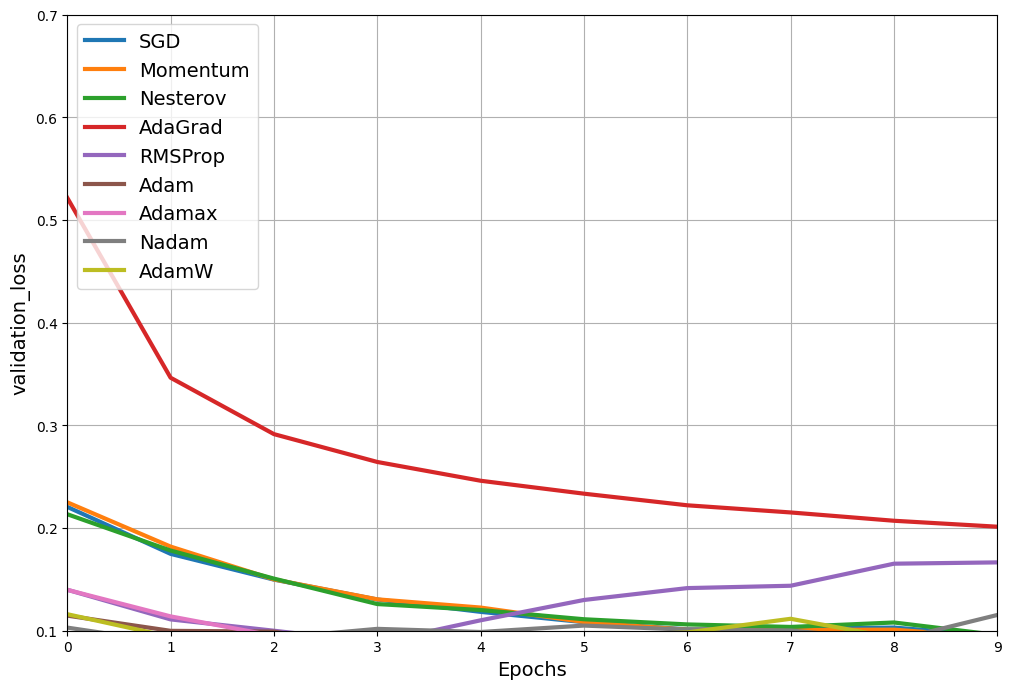

In [68]:
for loss in ("loss", "val_loss"):
    plt.figure(figsize=(12, 8))
    opt_names = "SGD Momentum Nesterov AdaGrad RMSProp Adam Adamax Nadam AdamW"
    for history, opt_name in zip((history_sgd, history_momentum, history_nesterov,
                                  history_adagrad, history_rmsprop, history_adam,
                                  history_adamax, history_nadam, history_adamw),
                                  opt_names.split()):
        plt.plot(history.history[loss], label=f"{opt_name}", linewidth=3)
    
    plt.grid()
    plt.xlabel("Epochs")
    plt.ylabel({"loss": "Training loss", "val_loss": "validation_loss"}[loss])
    plt.legend(loc="upper left")
    plt.axis([0, 9, 0.1, 0.7])
    plt.show()

## Learning Rate Scheduling

### Power Scheduling

```lr = lr0 / (1 + steps / s)**c```

* Keras uses `c=1` and `s = 1 / decay`

In [69]:
optimizer = tf.keras.optimizers.SGD(learning_rate=0.01, decay=1e-4)

In [70]:
history_power_scheduling = build_and_train_model(optimizer)

Epoch 1/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.5570 - accuracy: 0.8418 - val_loss: 0.2347 - val_accuracy: 0.9378
Epoch 2/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.2695 - accuracy: 0.9210 - val_loss: 0.1940 - val_accuracy: 0.9442
Epoch 3/10
1719/1719 [==============================] - 4s 3ms/step - loss: 0.2198 - accuracy: 0.9361 - val_loss: 0.1574 - val_accuracy: 0.9556
Epoch 4/10
1719/1719 [==============================] - 4s 3ms/step - loss: 0.1887 - accuracy: 0.9450 - val_loss: 0.1428 - val_accuracy: 0.9612
Epoch 5/10
1719/1719 [==============================] - 4s 3ms/step - loss: 0.1673 - accuracy: 0.9516 - val_loss: 0.1317 - val_accuracy: 0.9650
Epoch 6/10
1719/1719 [==============================] - 4s 3ms/step - loss: 0.1523 - accuracy: 0.9555 - val_loss: 0.1240 - val_accuracy: 0.9650
Epoch 7/10
1719/1719 [==============================] - 4s 3ms/step - loss: 0.1402 - accuracy: 0.9586 - val_loss: 0.1171 - val_accuracy:

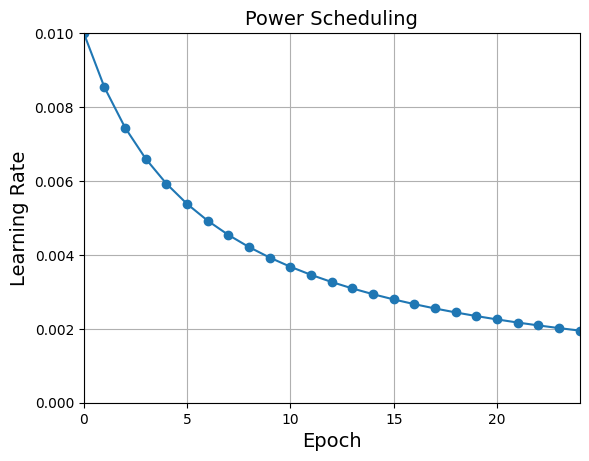

In [71]:
import math

learning_rate = 0.01
decay = 1e-4
batch_size = 32
n_steps_per_epoch = math.ceil(len(X_train) / batch_size)
n_epochs = 25

epochs = np.arange(n_epochs)
lrs = learning_rate / (1 + decay * epochs * n_steps_per_epoch)

plt.plot(epochs, lrs, "o-")
plt.axis([0, n_epochs - 1, 0, 0.01])
plt.xlabel("Epoch")
plt.ylabel("Learning Rate")
plt.title("Power Scheduling", fontsize=14)
plt.grid(True)
plt.show()

### Exponential Scheduling

```lr = lr0 * 0.1 ** (epoch / s)```

In [72]:
def exponential_decay_fn(epoch):
    return 0.01 * 0.1 ** (epoch / 20)

In [74]:
def exponential_decay(lr0, s):
    def exponential_decay_fn(epoch):
        return lr0 * 0.1 ** (epoch / s)
    return exponential_decay_fn

exponential_decay_fn = exponential_decay(lr0=0.01, s = 20)

In [75]:
# build and compile a model for fashion MNIST

tf.random.set_seed(42)
model = build_model()
optimizer = tf.keras.optimizers.SGD(learning_rate=0.001)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])

In [76]:
lr_scheduler = tf.keras.callbacks.LearningRateScheduler(exponential_decay_fn)
history = model.fit(X_train, y_train, epochs=n_epochs,
                    validation_data=(X_valid, y_valid),
                    callbacks=[lr_scheduler])

Epoch 1/25
1719/1719 [==============================] - 5s 3ms/step - loss: 0.5343 - accuracy: 0.8488 - val_loss: 0.2293 - val_accuracy: 0.9380 - lr: 0.0100
Epoch 2/25
1719/1719 [==============================] - 5s 3ms/step - loss: 0.2549 - accuracy: 0.9264 - val_loss: 0.1846 - val_accuracy: 0.9498 - lr: 0.0089
Epoch 3/25
1719/1719 [==============================] - 5s 3ms/step - loss: 0.2054 - accuracy: 0.9416 - val_loss: 0.1514 - val_accuracy: 0.9592 - lr: 0.0079
Epoch 4/25
1719/1719 [==============================] - 4s 3ms/step - loss: 0.1754 - accuracy: 0.9492 - val_loss: 0.1363 - val_accuracy: 0.9610 - lr: 0.0071
Epoch 5/25
1719/1719 [==============================] - 5s 3ms/step - loss: 0.1549 - accuracy: 0.9560 - val_loss: 0.1251 - val_accuracy: 0.9652 - lr: 0.0063
Epoch 6/25
1719/1719 [==============================] - 4s 3ms/step - loss: 0.1405 - accuracy: 0.9600 - val_loss: 0.1206 - val_accuracy: 0.9656 - lr: 0.0056
Epoch 7/25
1719/1719 [==============================] - 5s

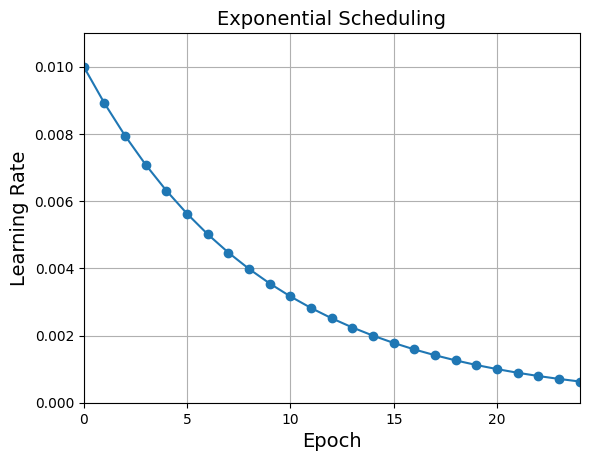

In [77]:
plt.plot(history.epoch, history.history["lr"], "o-")
plt.axis([0, n_epochs - 1, 0, 0.011])
plt.xlabel("Epoch")
plt.ylabel("Learning Rate")
plt.title("Exponential Scheduling", fontsize=14)
plt.grid(True)
plt.show()

The schedule function can take the current learning rate as a second argument:

In [78]:
def exponential_decay_fn(epoch, lr):
    return lr * 0.1 ** (1 / 20)

If you want to update the learning rate at each iteration rather than at each epoch, you can write your own callback class:

In [79]:
K = tf.keras.backend

class ExponentialDecay(tf.keras.callbacks.Callback):
    def __init__(self, n_steps=40_000):
        super().__init__()
        self.n_steps = n_steps

    def on_batch_begin(self, batch, logs=None):
        lr = K.get_value(self.model.optimizer.learning_rate)
        new_learning_rate = lr * 0.1 ** (1 / self.n_steps)
        K.set_value(self.model.optimizer.learning_rate, new_learning_rate)

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        logs['lr'] = K.get_value(self.model.optimizer.learning_rate)

In [80]:
lr0 = 0.01
model = build_model()
optimizer = tf.keras.optimizers.SGD(learning_rate=lr0)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])

In [81]:
n_epochs = 25
batch_size = 32
n_steps = n_epochs * math.ceil(len(X_train) / batch_size)
exp_decay = ExponentialDecay(n_steps)
history = model.fit(X_train, y_train, epochs=n_epochs,
                    validation_data=(X_valid, y_valid),
                    callbacks=[exp_decay])

Epoch 1/25
1719/1719 [==============================] - 8s 5ms/step - loss: 0.5543 - accuracy: 0.8429 - val_loss: 0.2273 - val_accuracy: 0.9368 - lr: 0.0091
Epoch 2/25
1719/1719 [==============================] - 8s 5ms/step - loss: 0.2595 - accuracy: 0.9231 - val_loss: 0.1856 - val_accuracy: 0.9464 - lr: 0.0083
Epoch 3/25
1719/1719 [==============================] - 8s 5ms/step - loss: 0.2080 - accuracy: 0.9389 - val_loss: 0.1485 - val_accuracy: 0.9556 - lr: 0.0076
Epoch 4/25
1719/1719 [==============================] - 7s 4ms/step - loss: 0.1775 - accuracy: 0.9478 - val_loss: 0.1372 - val_accuracy: 0.9620 - lr: 0.0069
Epoch 5/25
1719/1719 [==============================] - 8s 4ms/step - loss: 0.1564 - accuracy: 0.9544 - val_loss: 0.1213 - val_accuracy: 0.9680 - lr: 0.0063
Epoch 6/25
1719/1719 [==============================] - 8s 4ms/step - loss: 0.1415 - accuracy: 0.9583 - val_loss: 0.1220 - val_accuracy: 0.9656 - lr: 0.0058
Epoch 7/25
1719/1719 [==============================] - 8s

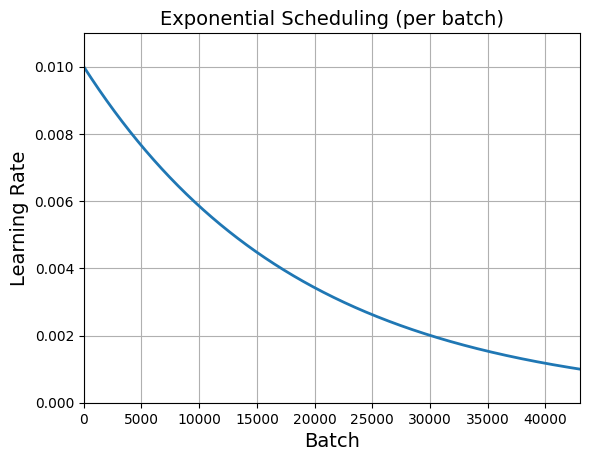

In [82]:
n_steps = n_epochs * math.ceil(len(X_train) / batch_size)
steps = np.arange(n_steps)
decay_rate = 0.1
lrs = lr0 * decay_rate ** (steps / n_steps)

plt.plot(steps, lrs, "-", linewidth=2)
plt.axis([0, n_steps - 1, 0, lr0 * 1.1])
plt.xlabel("Batch")
plt.ylabel("Learning Rate")
plt.title("Exponential Scheduling (per batch)", fontsize=14)
plt.grid(True)
plt.show()

### Piecewise Constant Scheduling

In [83]:
def piecewise_constant_fn(epoch):
    if epoch < 5:
        return 0.01
    elif epoch < 15:
        return 0.005
    else:
        return 0.001

In [84]:
def piecewise_constant(boundaries, values):
    boundaries = np.array([0] + boundaries)
    values = np.array(values)
    def piecewise_constant_fn(epoch):
        return values[(boundaries > epoch).argmax() - 1]
    return piecewise_constant_fn

piecewise_constant_fn = piecewise_constant([5, 15], [0.01, 0.005, 0.001])

In [85]:
n_epochs = 25

lr_scheduler = tf.keras.callbacks.LearningRateScheduler(piecewise_constant_fn)

model = build_model()
optimizer = tf.keras.optimizers.Nadam(learning_rate=lr0)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])
history = model.fit(X_train, y_train, epochs=n_epochs,
                    validation_data=(X_valid, y_valid),
                    callbacks=[lr_scheduler])

Epoch 1/25
1719/1719 [==============================] - 10s 5ms/step - loss: 0.3164 - accuracy: 0.9113 - val_loss: 0.1535 - val_accuracy: 0.9592 - lr: 0.0100
Epoch 2/25
1719/1719 [==============================] - 9s 5ms/step - loss: 0.2053 - accuracy: 0.9461 - val_loss: 0.1722 - val_accuracy: 0.9570 - lr: 0.0100
Epoch 3/25
1719/1719 [==============================] - 9s 5ms/step - loss: 0.1796 - accuracy: 0.9526 - val_loss: 0.1501 - val_accuracy: 0.9636 - lr: 0.0100
Epoch 4/25
1719/1719 [==============================] - 10s 6ms/step - loss: 0.1631 - accuracy: 0.9579 - val_loss: 0.1273 - val_accuracy: 0.9670 - lr: 0.0100
Epoch 5/25
1719/1719 [==============================] - 10s 6ms/step - loss: 0.1456 - accuracy: 0.9634 - val_loss: 0.1437 - val_accuracy: 0.9642 - lr: 0.0100
Epoch 6/25
1719/1719 [==============================] - 10s 6ms/step - loss: 0.0935 - accuracy: 0.9753 - val_loss: 0.1189 - val_accuracy: 0.9712 - lr: 0.0050
Epoch 7/25
1719/1719 [==============================] 

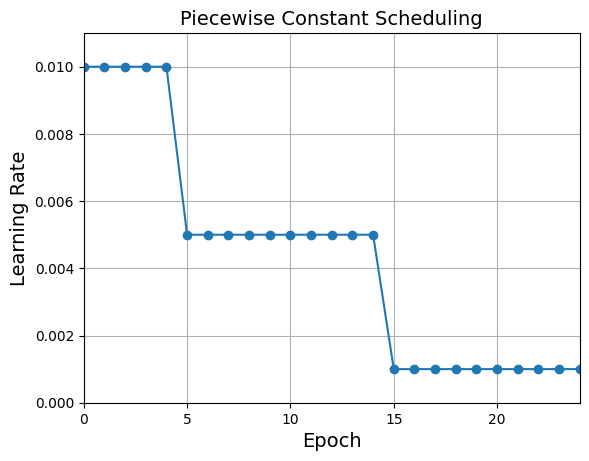

In [86]:
plt.plot(history.epoch, history.history["lr"], "o-")
plt.axis([0, n_epochs - 1, 0, 0.011])
plt.xlabel("Epoch")
plt.ylabel("Learning Rate")
plt.title("Piecewise Constant Scheduling", fontsize=14)
plt.grid(True)
plt.show()

### Performance Scheduling

In [88]:
model = build_model()
optimizer = tf.keras.optimizers.SGD(learning_rate=lr0)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])

In [89]:
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=5)
history = model.fit(X_train, y_train, epochs=n_epochs,
                    validation_data=(X_valid, y_valid),
                    callbacks=[lr_scheduler])

Epoch 1/25
1719/1719 [==============================] - 6s 3ms/step - loss: 0.5327 - accuracy: 0.8466 - val_loss: 0.2279 - val_accuracy: 0.9380 - lr: 0.0100
Epoch 2/25
1719/1719 [==============================] - 5s 3ms/step - loss: 0.2541 - accuracy: 0.9250 - val_loss: 0.1801 - val_accuracy: 0.9480 - lr: 0.0100
Epoch 3/25
1719/1719 [==============================] - 5s 3ms/step - loss: 0.1976 - accuracy: 0.9420 - val_loss: 0.1427 - val_accuracy: 0.9606 - lr: 0.0100
Epoch 4/25
1719/1719 [==============================] - 5s 3ms/step - loss: 0.1636 - accuracy: 0.9519 - val_loss: 0.1296 - val_accuracy: 0.9620 - lr: 0.0100
Epoch 5/25
1719/1719 [==============================] - 5s 3ms/step - loss: 0.1402 - accuracy: 0.9582 - val_loss: 0.1123 - val_accuracy: 0.9692 - lr: 0.0100
Epoch 6/25
1719/1719 [==============================] - 5s 3ms/step - loss: 0.1234 - accuracy: 0.9637 - val_loss: 0.1098 - val_accuracy: 0.9682 - lr: 0.0100
Epoch 7/25
1719/1719 [==============================] - 5s

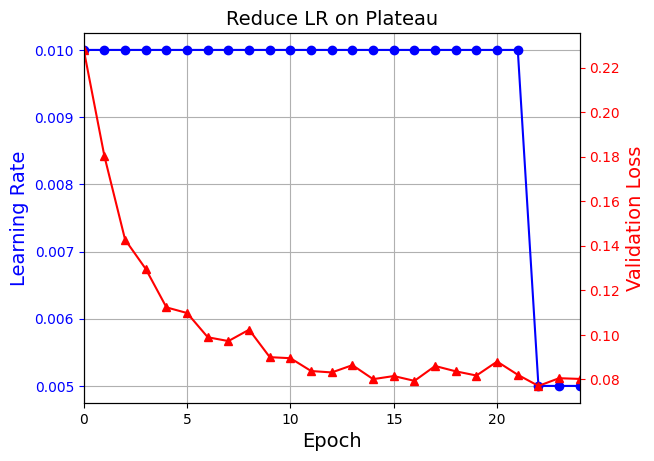

In [90]:
plt.plot(history.epoch, history.history["lr"], "bo-")
plt.xlabel("Epoch")
plt.ylabel("Learning Rate", color="b")
plt.tick_params('y', colors='b')
plt.gca().set_xlim(0, n_epochs - 1)
plt.grid(True)

ax2 = plt.gca().twinx()
ax2.plot(history.epoch, history.history["val_loss"], "r^-")
ax2.set_ylabel("Validation Loss", color='r')
ax2.tick_params('y', colors='r')

plt.title("Reduce LR on Plateau", fontsize=14)
plt.show()

### tf.keras schedulers

In [91]:
import math

batch_size = 42
n_epochs = 25
n_steps = n_epochs * math.ceil(len(X_train) / batch_size)
scheduled_learning_rate = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.01, decay_steps=n_steps, decay_rate=0.1)
optimizer = tf.keras.optimizers.SGD(learning_rate=scheduled_learning_rate)

In [92]:
model = build_and_train_model(optimizer)

Epoch 1/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.5623 - accuracy: 0.8425 - val_loss: 0.2301 - val_accuracy: 0.9406
Epoch 2/10
1719/1719 [==============================] - 4s 3ms/step - loss: 0.2578 - accuracy: 0.9267 - val_loss: 0.1836 - val_accuracy: 0.9514
Epoch 3/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.2058 - accuracy: 0.9403 - val_loss: 0.1535 - val_accuracy: 0.9606
Epoch 4/10
1719/1719 [==============================] - 4s 3ms/step - loss: 0.1757 - accuracy: 0.9490 - val_loss: 0.1378 - val_accuracy: 0.9648
Epoch 5/10
1719/1719 [==============================] - 4s 3ms/step - loss: 0.1552 - accuracy: 0.9557 - val_loss: 0.1257 - val_accuracy: 0.9678
Epoch 6/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.1415 - accuracy: 0.9593 - val_loss: 0.1210 - val_accuracy: 0.9672
Epoch 7/10
1719/1719 [==============================] - 4s 3ms/step - loss: 0.1301 - accuracy: 0.9627 - val_loss: 0.1122 - val_accuracy:

In [94]:
# shows how to use PiecewiseConstantDecay
scheduled_learning_rate = tf.keras.optimizers.schedules.PiecewiseConstantDecay(
    boundaries=[5. * n_steps_per_epoch, 15. * n_steps_per_epoch],
    values=[0.01, 0.005, 0.001]
)

### 1Cycle scheduling

The `ExponentialLearningRate` custom callback updates the learning rate during training, at the end of each batch. It multiplies it by a constant `factor`. It also saves the learning rate and loss at each batch. Since `logs["loss"]` is actually the mean loss since the start of the epoch, and we want to save the batch loss instead, we must compute the mean times the number of batches since the beginning of the epoch to get the total loss so far, then we subtract the total loss at the previous batch to get the current batch's loss.

In [97]:
K = tf.keras.backend

class ExponentialLearningRate(tf.keras.callbacks.Callback):
    def __init__(self, factor):
        self.factor = factor
        self.rates = []
        self.losses = []

    def on_epoch_begin(self, epoch, logs=None):
        self.sum_of_epoch_losses = 0

    def on_batch_end(self, batch, logs=None):
        mean_epoch_loss = logs["loss"]
        new_sum_of_epoch_losses = mean_epoch_loss * (batch + 1)
        batch_loss = new_sum_of_epoch_losses - self.sum_of_epoch_losses
        self.sum_of_epoch_losses = new_sum_of_epoch_losses
        self.rates.append(K.get_value(self.model.optimizer.learning_rate))
        self.losses.append(batch_loss)
        K.set_value(self.model.optimizer.learning_rate,
                    self.model.optimizer.learning_rate * self.factor)

The `find_learning_rate()` function trains the model using the `ExponentialLearningRate` callback, and it returns the learning rates and corresponding batch losses. At the end, it restores the model and its optimizers to their initial state.

In [98]:
def find_learning_rate(model, X, y, epochs=1, batch_size=32, min_rate=1e-4,
                       max_rate=1):
    init_weights = model.get_weights()
    iterations = math.ceil(len(X) / batch_size) * epochs
    factor = (max_rate / min_rate) ** (1 / iterations)
    init_lr = K.get_value(model.optimizer.learning_rate)
    K.set_value(model.optimizer.learning_rate, min_rate)
    exp_lr = ExponentialLearningRate(factor)
    history = model.fit(X, y, epochs=epochs, batch_size=batch_size,
                        callbacks=[exp_lr])
    K.set_value(model.optimizer.learning_rate, init_lr)
    model.set_weights(init_weights)
    return exp_lr.rates, exp_lr.losses

The `plot_lr_vs_loss()` function plots the learning rates vs the losses. The optimal learning rate to use the maximum learning rate in 1cycle is near the bottom of the curve.

In [99]:
def plot_lr_vs_loss(rates, losses):
    plt.plot(rates, losses, "b")
    plt.gca().set_xscale('log')
    max_loss = losses[0] + min(losses)
    plt.hlines(min(losses), min(rates), max(rates), color="k")
    plt.axis([min(rates), max(rates), 0, max_loss])
    plt.xlabel("Learning rate")
    plt.ylabel("Loss")
    plt.grid()

Let's build a simple Fashion MNIST model and compile it

In [100]:
model = build_model()
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=tf.keras.optimizers.SGD(learning_rate=0.001),
              metrics=["accuracy"])

Now let's find the optimal max learning rate for 1cycle:

430/430 [==============================] - 1s 3ms/step - loss: 1.8092 - accuracy: 0.3926


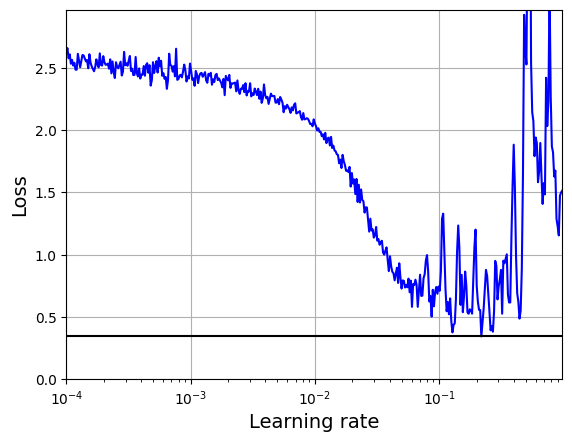

In [102]:
batch_size = 128
rates, losses = find_learning_rate(model, X_train, y_train, epochs=1,
                                   batch_size=batch_size)
plot_lr_vs_loss(rates, losses)

Looks like the max learning_rate to use for 1cycle is around 10<sup>-1</sup>.

The `OneCycleScheduler` custom callback updates the learning rate at the beginning of each batch. It applies the logic described in the book: increase the learning rate linearly during about half of training, then reduce it linearly back to the initial learning rate, and lastly reduce it down to close to zero linearly for the very last part of training.